In [ ]:
#import the required libraries and packages
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
import skimage
import matplotlib.pyplot as plt
from skimage.feature import canny
import cv2
import shutil
import random
import numpy as np


In [ ]:
#load the dataset
dataset_path = r"C:\Users\Azeem\Downloads\Deepdive"

train_dir = os.path.join(dataset_path, "train")
test_dir = os.path.join(dataset_path, "test")
validation_dir = os.path.join(dataset_path, "validation")

In [ ]:
#All three sets are preprocessed here
train_data = ImageDataGenerator(rescale= 1.0/255)
test_data = ImageDataGenerator(rescale= 1.0/255)
validation_data = ImageDataGenerator(rescale= 1.0/255)

train_generator = train_data.flow_from_directory(
    train_dir,
    target_size = (224,224),
    class_mode = "categorical",
    batch_size = 32
)

test_generator = test_data.flow_from_directory(
    test_dir,
    target_size = (224,224),
    class_mode = "categorical",
    batch_size = 32
)

validation_generator = validation_data.flow_from_directory(
    validation_dir,
    target_size = (224,224),
    class_mode = "categorical",
    batch_size = 32
)

Found 2667 images belonging to 33 classes.
Found 660 images belonging to 33 classes.
Found 667 images belonging to 33 classes.


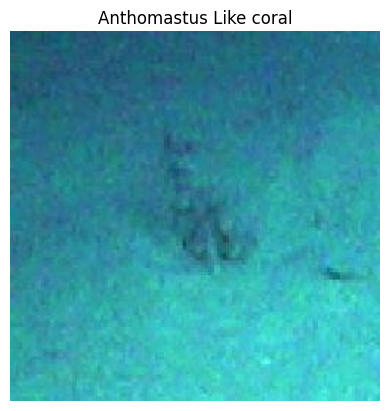

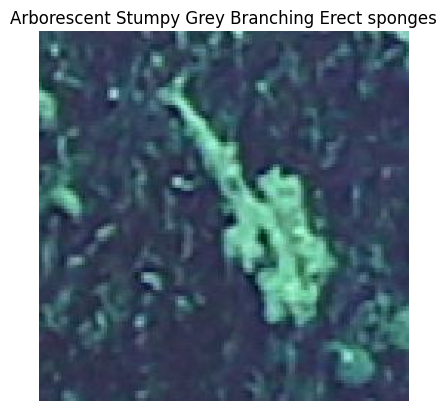

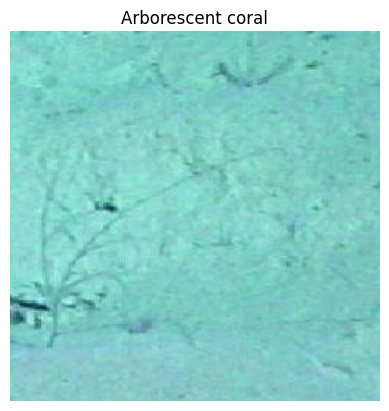

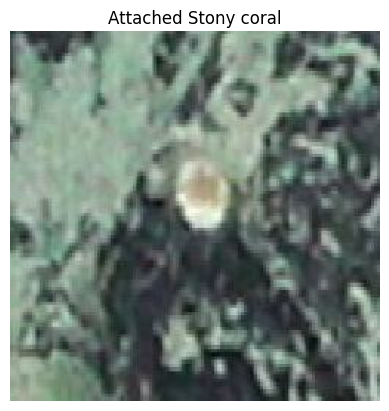

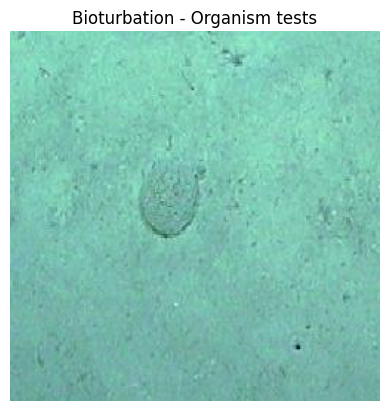

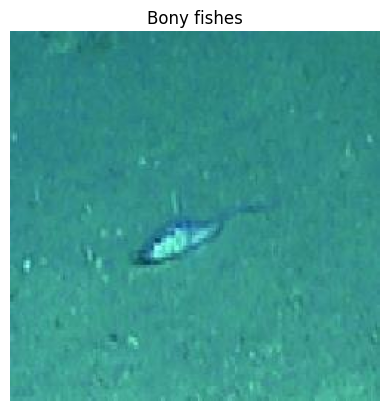

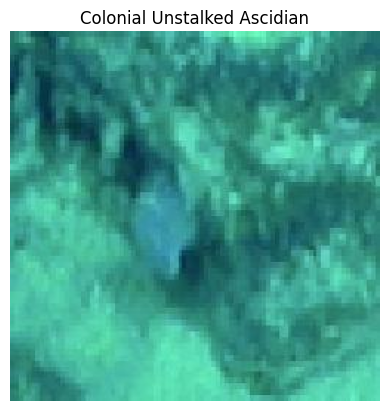

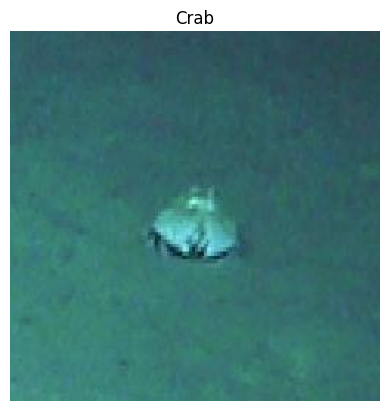

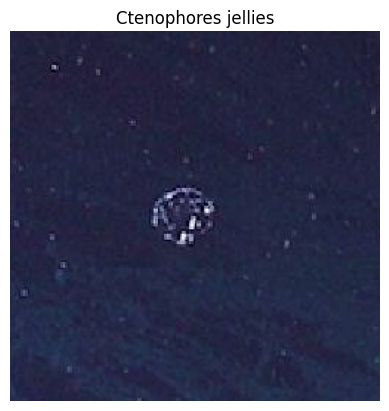

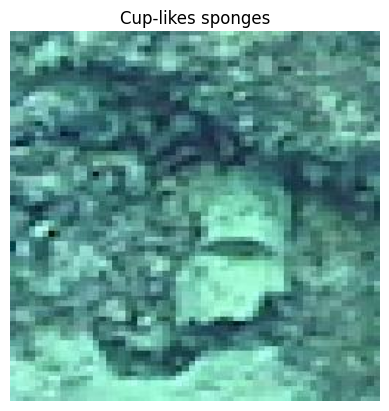

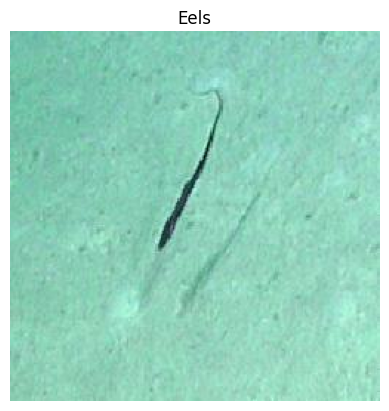

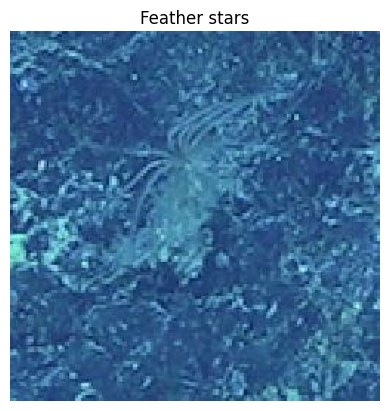

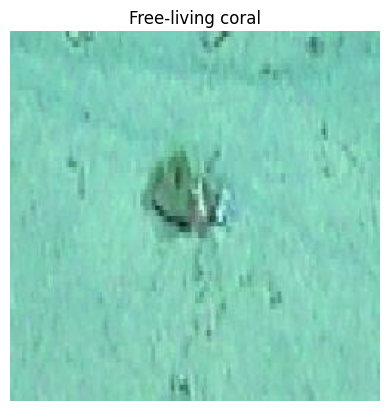

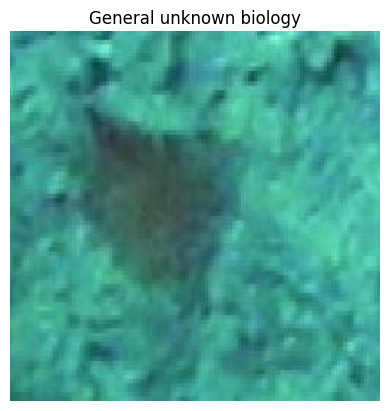

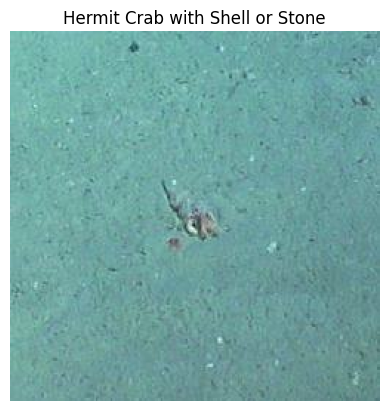

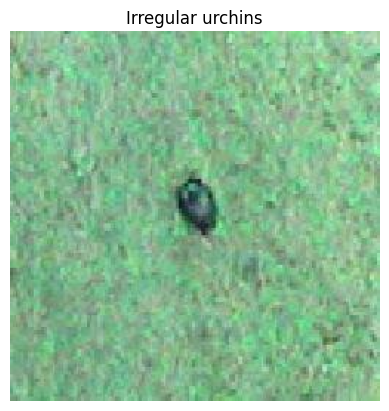

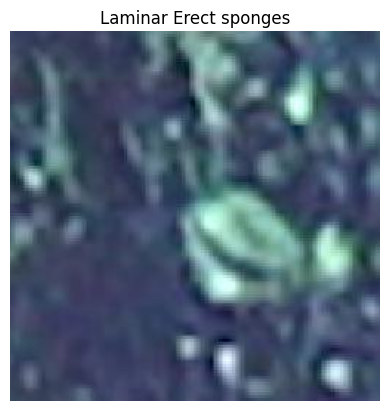

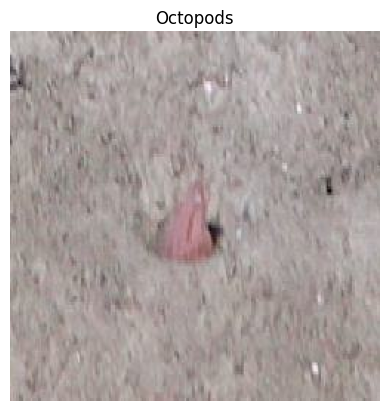

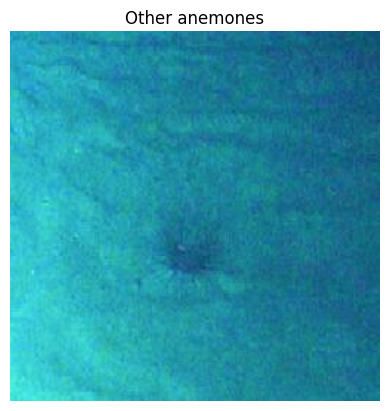

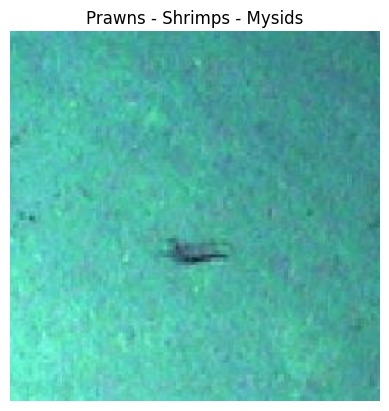

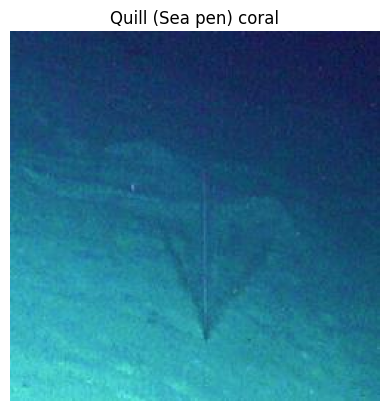

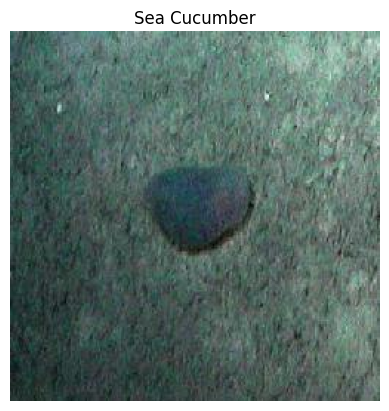

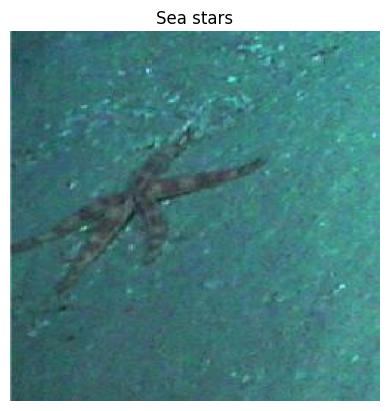

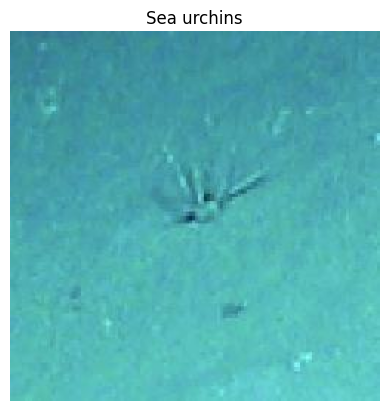

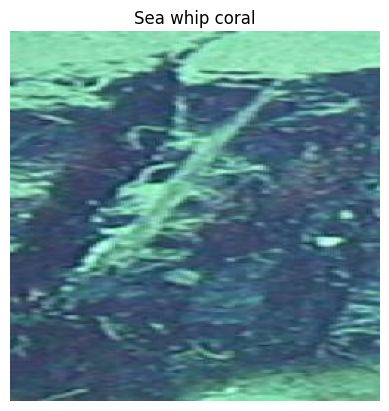

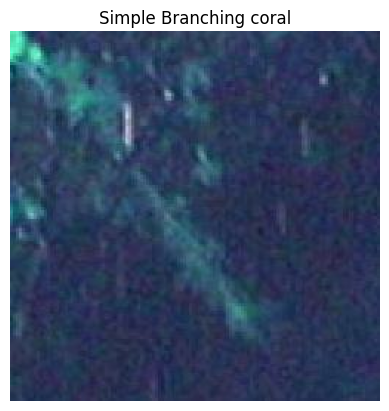

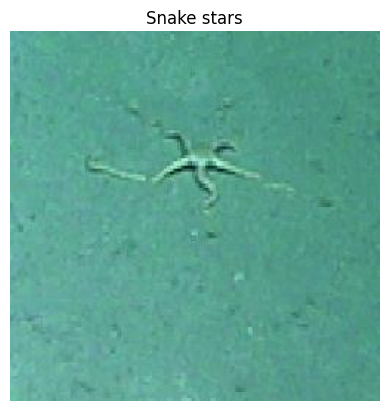

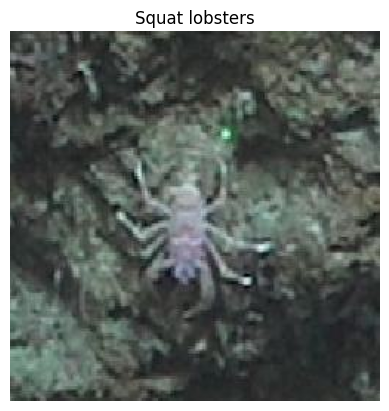

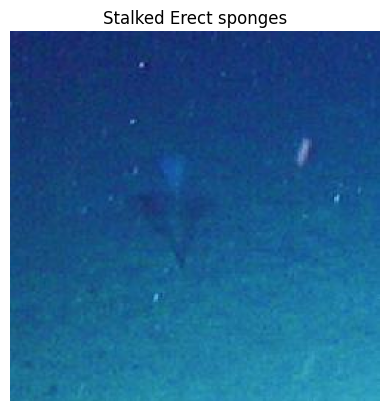

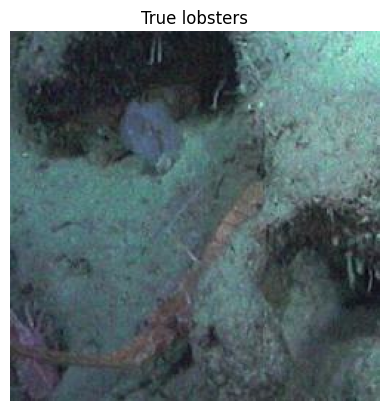

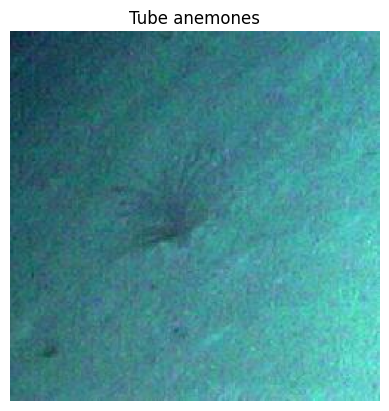

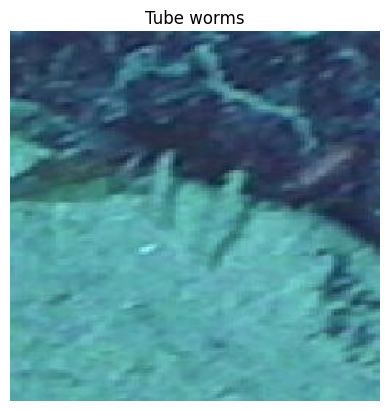

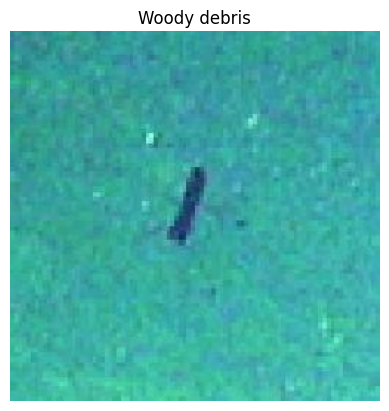

In [ ]:
class_indices = train_generator.class_indices
images_per_class = {}

for class_name in list(class_indices.keys()):
    class_dir = os.path.join(train_dir, class_name)
    images = list(os.listdir(class_dir))

    images_per_class[class_name] = os.path.join(class_dir, images[0])

class_names = list(images_per_class.keys())

for class_name, image in images_per_class.items():
    img = load_img(image)
    plt.imshow(img)
    plt.title(class_name)
    plt.axis("off")
    plt.show()

**Data Processing Functions**

In [ ]:

#source = train_dir, so use for loop on sub folders
def median_noise(source, blur = 3):
        img = source
        median = cv2.medianBlur(img, blur)
        return (median)

def gaussian_noise(source,kernal = (5,5), blur = 5):
        img = source
        gaussian = cv2.GaussianBlur(img, kernal, blur)
        return (gaussian)


def adaptive_histogram_equalization(source):
        img = source
        # Convert to LAB color space
        lab_image = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
        l, a, b = cv2.split(lab_image)

        # Apply CLAHE to the L channel
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        l_clahe = clahe.apply(l)

        # Merge channels and convert back to BGR
        lab_clahe = cv2.merge((l_clahe, a, b))
        result = cv2.cvtColor(lab_clahe, cv2.COLOR_LAB2BGR)

        return (result)


def resize(source, size = (224,224)):
        img = source
        result = cv2.resize(img, size)
        return (result)

def grayscale(source):
        return cv2.imread(source, cv2.IMREAD_GRAYSCALE)

def histogram_equalize(source):
        img = source
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        eq_img = cv2.equalizeHist(gray)

        return (eq_img)

def standard_img(source):
        img = source
        if img.dtype == bool:
                img = img.astype(np.uint8) * 255
        mean, std = cv2.meanStdDev(img)

        mean, std = cv2.meanStdDev(img)
        if len(img.shape) == 2 or img.shape[2] == 1:  # Grayscale
                mean = mean.reshape((1, 1, 1))
                std = std.reshape((1, 1, 1))
        else:  # Color (3 channels)
                mean = mean.reshape((1, 1, 3))
                std = std.reshape((1, 1, 3))
        std_img = (img - mean) / std

        return (std_img)

def thresholding(source):
        img = source
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        _, binary  = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY_INV)
        return (binary)


In [ ]:
def preprocess_image(source):
    img_path = source

    if isinstance(img_path, str):
        img = cv2.imread(img_path)
    else:
        img = img_path

    if img is None:
        raise ValueError("Could not load image")


    resized = resize(img)
    denoised = gaussian_noise(resized, blur=5)
    equalized = adaptive_histogram_equalization(denoised)
    threshold = thresholding(equalized)
    normalized = standard_img(threshold)

    img = normalized

    if len(img.shape) == 3 and img.shape[0] == 1:
        img = img.squeeze()

    return img



**Data Augmentation Functions**

In [ ]:
def r_90_c(source):
    return cv2.rotate(cv2.imread(source, cv2.IMREAD_UNCHANGED), cv2.ROTATE_90_CLOCKWISE)

def r_90_ac(source):
    return cv2.rotate(cv2.imread(source, cv2.IMREAD_UNCHANGED), cv2.ROTATE_90_COUNTERCLOCKWISE)

def r_180(source):
    return cv2.rotate(cv2.imread(source, cv2.IMREAD_UNCHANGED), cv2.ROTATE_180)

def flip_h(source):
    return cv2.flip(cv2.imread(source, cv2.IMREAD_UNCHANGED), 0)

def flip_v(source):
    return cv2.flip(cv2.imread(source, cv2.IMREAD_UNCHANGED), 1)

def shifting(source, offset = (-50, 50)):
    x_shift = random.randint(offset[0], offset[1])
    y_shift = random.randint(offset[0], offset[1])

    img = cv2.imread(source, cv2.IMREAD_UNCHANGED)
    rows, cols = img.shape[:2]

    translation_matrix = np.float32([[1, 0, x_shift], [0, 1, y_shift]])

    # Perform the translation
    shifted_image = cv2.warpAffine(img, translation_matrix, (cols, rows))

    # Calculate the cropping region
    x_start = max(0, x_shift)
    y_start = max(0, y_shift)
    x_end = cols - max(0, -x_shift)
    y_end = rows - max(0, -y_shift)

    # Crop the shifted image to remove the black border
    cropped_image = shifted_image[y_start:y_end, x_start:x_end]

    return cv2.resize(cropped_image, (224,224))

def blur(source, blur_type="gaussian", kernel_size=(5, 5)):
    image = cv2.imread(source, cv2.IMREAD_UNCHANGED)

    if blur_type == "average":
        return cv2.blur(image, kernel_size)
    elif blur_type == "gaussian":
        return cv2.GaussianBlur(image, kernel_size, 0)


In [ ]:
#Seprate folders are created in the dataset_path for new processed and augmented images, following the same directory names within.
train_augmented = os.path.join(dataset_path, "train_augmented")
train_processed = os.path.join(dataset_path, "train_processed")

augmentation = [r_90_c, r_90_ac, r_180, flip_h, flip_v, shifting, blur]

In [ ]:
shutil.copytree(train_dir, train_augmented)

'C:\\Users\\Azeem\\Downloads\\Deepdive\\train_augmented'

In [ ]:
folders = os.listdir(train_augmented)

for folder in folders:
    folder_path = os.path.join(train_augmented, folder)
    images_path = os.listdir(folder_path)

    for i , img in enumerate(images_path):
        img_path = os.path.join(folder_path, img)

        if img is None:
            print(f"Error loading image: {img_path}")
            continue

        augment_i = (i // 5) % len(augmentation)
        augmentation_func = augmentation[augment_i]
        result = augmentation_func(img_path)


        original_name, ext = os.path.splitext(img)
        new_file_name = f"{original_name}_augmented.jpg"

        # Save the result in the same folder with the new name
        new_file_path = os.path.join(folder_path, new_file_name)
        cv2.imwrite(new_file_path, result)
        os.remove(img_path)


In [ ]:
shutil.copytree(train_dir, train_processed)

'C:\\Users\\Azeem\\Downloads\\Deepdive\\train_processed'

In [ ]:
folders = os.listdir(train_processed)

for folder in folders:
    folder_path = os.path.join(train_processed, folder)

    images_path = os.listdir(folder_path)

    for i , img in enumerate(images_path):
        img_path  = img_path = os.path.join(folder_path, img)
        if img is None:
            print(f"Error loading image: {img_path}")
            continue

        result = preprocess_image(img_path)

        # Normalize to [0, 255] to save them in the directory.
        result = np.clip(result, 0, 1)
        result = (result * 255).astype(np.uint8)
        original_name, ext = os.path.splitext(img)
        new_file_name = f"{original_name}_processed.jpg"


        new_file_path = os.path.join(folder_path, new_file_name)
        cv2.imwrite(new_file_path, result)


C:\Users\Azeem\AppData\Local\Temp\ipykernel_20360\1031991995.py:58: RuntimeWarning: invalid value encountered in divide
  std_img = (img - mean) / std
C:\Users\Azeem\AppData\Local\Temp\ipykernel_20360\1993508207.py:18: RuntimeWarning: invalid value encountered in cast
  result = (result * 255).astype(np.uint8)  # Scale to [0, 255] and convert to uint8
